# Explainer Notebook

#### - Get all links in initial page
#### - Make dataframe with columns: [URL, Title, List references, List paragraph texts]

In [237]:
# Options
OPTION_PERFORM_SCRAPE = False
OPTION_SAVE_FIG = False
OPTION_SHOW_PLOT = True

In [167]:
# Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
from util import wiki_util
from tqdm import tqdm
from ast import literal_eval
from collections import defaultdict
import networkx as nx
from netwulf.interactive import visualize
import matplotlib.pyplot as plt
import numpy as np


In [239]:
# Static Variables
LINK_WIKI_ENGLISH = "https://en.wikipedia.org/wiki/Cold_War"
LINK_WIKI_GERMAN = "https://de.wikipedia.org/wiki/Kalter_Krieg"
EVENT_FILTER = ["conflicts", "conflict", "events", "event", "wars", "war", "coups", "coup",
                "crises", "crisis", "coup d'état", "history", "warfare", "battle", "battles"
                "invasion", "invasions", "revolution", "revolutions"]
PERSON_FILTER = ["births", "deaths", "people", "leader", "leaders", "politicians", "politician",
                 "writer", "writers", "scientist", "scientists", "personnel", "family", "families",
                 "executive", "executives", "spy", "spies"]

In [93]:
def get_content_soup(link_wikipedia):
    website = requests.get(link_wikipedia)
    content_soup = BeautifulSoup(website.content)
    return content_soup

def soup_get_title(wiki_content_soup):
    head = wiki_content_soup.find("h1", {"id": "firstHeading"})
    return head.text

def soup_get_reference_links(wiki_content_soup, language="en"):
    p_elements = wiki_content_soup.find_all("p")
    links = [a['href'] for p in p_elements for a in p.find_all("a", href=True)]
    links = [wiki_util.hyperlink_cleanup(link, language) for link in links]
    links = [link for link in links if link != False]
    return links

def soup_get_category_texts(wiki_content_soup, language="en"):
    html_div = wiki_content_soup.find("div", {"id": "mw-normal-catlinks"})
    links_without_categories = html_div.find("ul")
    links = links_without_categories.find_all("a")
    link_texts = [a.text for a in links]
    return link_texts

def soup_get_paragraph_texts(wiki_content_soup):
    p_elements = wiki_content_soup.find_all("p")
    paragraph_texts = [p.text for p in p_elements]
    return paragraph_texts

def get_all_reference_links(link_wikipedia, language):
    website = requests.get(link_wikipedia)
    content_soup = BeautifulSoup(website.content)
    p_elements = content_soup.find_all("p")
    links = [a['href'] for p in p_elements for a in p.find_all("a", href=True)]
    links = [wiki_util.hyperlink_cleanup(link, language) for link in links]
    links = [link for link in links if link != False]
    return links


In [94]:
# Scrape English version
if OPTION_PERFORM_SCRAPE:
    links_to_scan = get_all_reference_links(LINK_WIKI_ENGLISH, "en") + [LINK_WIKI_ENGLISH]
    links_to_scan = sorted(list(set(links_to_scan)))
    data = []
    for url in tqdm(links_to_scan):
        soup = get_content_soup(url)
        title = soup_get_title(soup)
        list_references = soup_get_reference_links(soup, language="en")
        list_paragraph_texts = soup_get_paragraph_texts(soup)
        list_category_texts = soup_get_category_texts(soup)
        data.append([url, title, list_references, list_paragraph_texts, list_category_texts])


In [95]:
# Save English version
if OPTION_PERFORM_SCRAPE:
    COLUMN_NAMES = ['URL', 'TITLE', 'LIST_REFERENCES', 'LIST_PARAGRAPH_TEXTS', "CATEGORIES"]
    df_wikipedia_english = pd.DataFrame(data, columns=COLUMN_NAMES)
    df_wikipedia_english = df_wikipedia_english.set_index('URL')
    df_wikipedia_english.to_csv('./data/wiki_english.csv')

In [96]:
# Scrape German Version
if OPTION_PERFORM_SCRAPE:
    links_to_scan = get_all_reference_links(LINK_WIKI_GERMAN, language="de") + [LINK_WIKI_GERMAN]
    links_to_scan = sorted(list(set(links_to_scan)))
    data = []
    for url in tqdm(links_to_scan):
        soup = get_content_soup(url)
        title = soup_get_title(soup)
        list_references = soup_get_reference_links(soup, language="de")
        list_paragraph_texts = soup_get_paragraph_texts(soup)
        list_category_texts = soup_get_category_texts(soup)
        data.append([url, title, list_references, list_paragraph_texts, list_category_texts])


In [97]:
# Save German Version
if OPTION_PERFORM_SCRAPE:
    COLUMN_NAMES = ['URL', 'TITLE', 'LIST_REFERENCES', 'LIST_PARAGRAPH_TEXTS', "CATEGORIES"]
    df_wikipedia_german = pd.DataFrame(data, columns=COLUMN_NAMES)
    df_wikipedia_german = df_wikipedia_german.set_index('URL')
    df_wikipedia_german.to_csv('./data/wiki_german.csv')

In [246]:
df_wikipedia_english_fromCSV = pd.read_csv('./data/wiki_english.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval})
df_wikipedia_german_fromCSV = pd.read_csv('./data/wiki_german.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval})

In [247]:
df_wikipedia_english_fromCSV

,TITLE,LIST_REFERENCES,LIST_PARAGRAPH_TEXTS,CATEGORIES
URL,,,,
"https://en.wikipedia.org/wiki/1,000,000,000_(number)","1,000,000,000","[https://en.wikipedia.org/wiki/Billion, https:...","[1,000,000,000 (one billion, short scale; one ...","[Integers, Large numbers]"
https://en.wikipedia.org/wiki/17th_parallel_north,17th parallel north,[https://en.wikipedia.org/wiki/Circle_of_latit...,[The 17th parallel north is a circle of latitu...,[Circles of latitude]
https://en.wikipedia.org/wiki/1947_Polish_legislative_election,1947 Polish legislative election,[https://en.wikipedia.org/wiki/Edward_Os%C3%B3...,"[\n, Edward Osóbka-Morawski\nPPS\n, Józef Cyra...","[Electoral fraud in Poland, 1947 elections in ..."
https://en.wikipedia.org/wiki/1948_Czechoslovak_coup_d%27%C3%A9tat,1948 Czechoslovak coup d'état,[https://en.wikipedia.org/wiki/Communist_Party...,"[\n, In late February 1948, the Communist Part...","[Cold War conflicts, 1948 in Czechoslovakia, P..."
https://en.wikipedia.org/wiki/1948_Italian_general_election,1948 Italian general election,[https://en.wikipedia.org/wiki/Alcide_De_Gaspe...,"[\n, Alcide De Gasperi\nChristian Democracy\n,...","[1948 elections in Europe, 1948 elections in I..."
...,...,...,...,...
https://en.wikipedia.org/wiki/Yekaterinburg,Yekaterinburg,[https://en.wikipedia.org/wiki/Help:IPA/Englis...,"[\n, Yekaterinburg (/jɪˈkætərɪnbɜːrɡ/ yih-KAT-...","[Yekaterinburg, Yekaterinburgsky Uyezd, Popula..."
https://en.wikipedia.org/wiki/Yom_Kippur_War,Yom Kippur War,"[https://en.wikipedia.org/wiki/Israel, https:/...","[\n, Egyptian front\n, International front\n, ...","[Yom Kippur War, 1973 in Egypt, Conflicts in 1..."
https://en.wikipedia.org/wiki/Yugoslavia,Yugoslavia,[https://en.wikipedia.org/wiki/Geographic_coor...,"[\n, Coordinates: 44°49′N 20°27′E﻿ / ﻿44.817°N...","[Yugoslavia, Former countries in the Balkans, ..."


In [254]:
def get_category(input_list):
    event_score = 0
    person_score = 0
    for item in input_list:
        for E in EVENT_FILTER:
            if E in item.lower():
                event_score +=1
        for P in PERSON_FILTER:
            if P in item.lower():
                person_score +=1
    if not event_score and not person_score:
        return "none"
    return "event" if event_score > person_score else "person"

In [255]:
df_wikipedia_english_fromCSV['TYPE'] = df_wikipedia_english_fromCSV.apply(lambda x: get_category(x['CATEGORIES']), axis=1)
# Virker til en vis grænse, nogle småting der ikke bliver fanget ordenligt. None filteret virker bedst.

In [300]:
df_wikipedia_english_fromCSV.groupby(['TYPE', 'TITLE']).count().transpose().person.transpose()

,LIST_REFERENCES,LIST_PARAGRAPH_TEXTS,CATEGORIES
TITLE,,,
Adam Rapacki,1,1,1
Adolf Hitler,1,1,1
Ahmad Husein,1,1,1
Albert Kahn (architect),1,1,1
Alcide De Gasperi,1,1,1
...,...,...,...
Wojciech Jaruzelski,1,1,1
Woodrow Wilson,1,1,1
Yasser Arafat,1,1,1


In [334]:
def df_get_url_list(df_wiki):
    return list(df_wiki.index)

def mask_list(base, to_mask):
    res = [o for o in to_mask if o in base]
    return res

# (a, b): count
reference_count = defaultdict(lambda:0)

url_list = df_get_url_list(df_wikipedia_english_fromCSV)
for url in tqdm(url_list):
    references = df_wikipedia_english_fromCSV["LIST_REFERENCES"][url]
    references = mask_list(url_list, references)

    for url_ref in references:
        reference_count[(url, url_ref)] += 1


100%|██████████| 860/860 [00:02<00:00, 365.92it/s]


In [335]:
print(len(reference_count.keys()))

19615


In [336]:
edge_list = []
for a in tqdm(url_list):
    for b in url_list:
        weight = reference_count[(a,b)]
        # weight += reference_count[(b,a)]
        if weight > 0:
            # if not ((a, b, weight) in edge_list or (b, a, weight) in edge_list):
            edge_list.append((a, b, weight))

100%|██████████| 860/860 [00:00<00:00, 1590.96it/s]


In [337]:
G = nx.DiGraph()
G.add_weighted_edges_from(edge_list)

In [338]:
for node in G.nodes:
    G.nodes[node]['Type'] = df_wikipedia_english_fromCSV[df_wikipedia_english_fromCSV.index == node].TYPE.tolist()[0]

In [343]:
nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get("Type") in ['event']
)
subgraph = G.subgraph(nodes)

In [345]:
#visualize(subgraph)

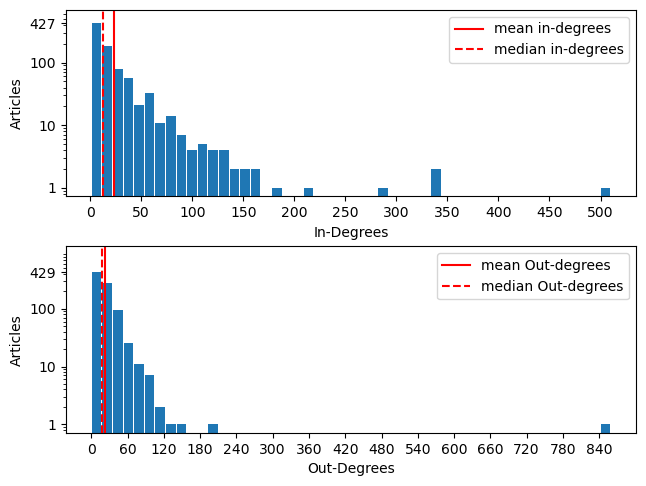

In [238]:
if OPTION_SHOW_PLOT:
    in_degrees = [x[1] for x in G.in_degree]
    out_degrees = [x[1] for x in G.out_degree]
    bins = np.linspace(min(in_degrees), max(in_degrees), 50)

    mean = np.mean(in_degrees)
    median = np.median(in_degrees)

    hist, edges = np.histogram(in_degrees, bins=bins)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1] - bins[0]
    fig, axs = plt.subplots(2)
    axs[0].bar(x, hist, width=width*0.9)

    axs[0].set_xlabel('In-Degrees')
    axs[0].set_ylabel('Articles')
    axs[0].set_yscale('log')
    axs[0].set_xticks(range(0, 501, 50))
    axs[0].set_yticks([10**0, 10**1, 10**2, max(hist)], labels=[10**0, 10**1, 10**2, max(hist)])
    axs[0].axline((mean, 0), (mean, max(in_degrees)), color='red', label='mean in-degrees')
    axs[0].axline((median, 0), (median, max(in_degrees)), linestyle='--', color='red', label='median in-degrees')
    axs[0].legend()

    bins = np.linspace(min(out_degrees), max(out_degrees), 50)

    mean = np.mean(out_degrees)
    median = np.median(out_degrees)

    hist, edges = np.histogram(out_degrees, bins=bins)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1] - bins[0]
    axs[1].bar(x, hist, width=width*0.9)

    axs[1].set_xlabel('Out-Degrees')
    axs[1].set_ylabel('Articles')
    axs[1].set_yscale('log')
    axs[1].set_xticks(range(0, int(max(list(bins))), 60))
    axs[1].set_yticks([10**0, 10**1, 10**2, max(hist)], labels=[10**0, 10**1, 10**2, max(hist)])
    axs[1].axline((mean, 0), (mean, max(out_degrees)), color='red', label='mean Out-degrees')
    axs[1].axline((median, 0), (median, max(out_degrees)), linestyle='--', color='red', label='median Out-degrees')
    axs[1].legend()
    fig.tight_layout(pad=0.5)
    plt.show()
    if OPTION_SAVE_FIG:
        fig.savefig("./images/degree_distributions.png")

In [104]:
# visualize(G)

(None, None)

In [105]:
config = {'zoom': 0.7629787234042553,
  'node_charge': -73.39458413926499,
  'node_gravity': 0,
  'link_distance': 15.53811411992263,
  'link_distance_variation': 0.07,
  'node_collision': True,
  'wiggle_nodes': False,
  'freeze_nodes': False,
  'node_fill_color': '#cdcdcd',
  'node_stroke_color': '#000000',
  'node_label_color': '#3c3c3c',
  'display_node_labels': False,
  'scale_node_size_by_strength': True,
  'node_size': 37.13249516441006,
  'node_stroke_width': 0.6179883945841392,
  'node_size_variation': 0.9652804642166344,
  'link_color': '#303f89',
  'link_width': 2.2345967117988392,
  'link_alpha': 0.24129593810444874,
  'link_width_variation': 1.3737911025145066,
  'display_singleton_nodes': True,
  'min_link_weight_percentile': 0,
  'max_link_weight_percentile': 1}
visualize(G, config=config)
print()

In [106]:
print("N nodes:", len(G.nodes))
print("N edges:", len(G.edges))


N nodes: 860
N edges: 19615
